## Echo Meeting 1st of February 2024

## Setup

In [13]:
%pip install pandas matplotlib seaborn spacy --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pathlib
import pandas as pd
import spacy
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
# define path of notebook
path = pathlib.Path.cwd()
sys.path.append(str(path.parents[0]/"src"))

## Notebook Overview
This notebook has the following sections: 
1. [General Progress Update](#general-progress-update)
2. [vLLM versus HF](#vllm-versus-hf)
3. [Peak at Data](#peaking-at-the-data)
4. [Help Wanted](#helped-wanted)

## General Progress Update
Since the last meeting, a lot of time has been focused on **optimizing inference time**. Specifically, three approaches have been attempted:
1. `Petals` (discarded completely as it did not scale well to our data, is unstable, and limits the models we can use)
2. `Quantized` models (although it allows us to download 70b models more quickly, the models still have high inference times with Hugging Face's implementation)
3. [vLLM](https://github.com/vllm-project/vllm) (library recommended by Kenneth, speeds up inference time drastically e.g., using a 7b beluga to generate 5000 rows in 18 minutes on 1 A100 with vLLM versus several hours with HF)

### Decisions
* As **vLLM** is crazy fast, it is more preferable to use it - allows for more flexibility. Some notes on differences between vLLM and HF is stated below.
* **new models**: code has been updated to easily add new models, and [mistral](https://huggingface.co/mistralai) has been added (with future versions hopefully allowing users to specify models in a config file instead of the current hard coding)

## vLLM versus HF

vLLM uses a different attention algorithm, implementing `Paged Attention` to speed up inference time. See more on their blog/docs/paper: https://blog.vllm.ai/2023/06/20/vllm.html 

Some concerns have been placed on vLLM's implementation versus Hugging Face's, mainly due to the fact that it does not produce the exact same outputs as a HF implementation of the model. This is likely due to small variations in how the sampling params are defined as well as their default values (see also this [google docs](https://docs.google.com/document/d/1lUfywV_0J-p-n_zbvnjKsZ6o9cEWYcD2AI7DELtIqJ4/edit?usp=sharing) made by me).

### Prepare Data

In [8]:
# load data
ai_datapath = path.parents[0] / "datasets" / "ai_datasets"

hf_df = pd.read_json(ai_datapath / "HF" / "prob_decoding" / "beluga7b" / "stories_prompt_1.ndjson", lines=True) # a test file with 1000 generations with HF implementation with temperature = 1

vllm_df = pd.read_json(ai_datapath / "vLLM" / "FULL_DATA" / "beluga7b" / "stories_prompt_1_temp1.ndjson", lines=True)
vllm_df = vllm_df.copy()[:1000]

# get doc length for hf 
nlp = spacy.blank("en")
hf_df["doc_length"] = hf_df[f"beluga7b_completions"].apply(lambda x: len(nlp(x)))

# subset 
vllm_df = vllm_df[["id", "beluga7b_completions", "doc_length"]]
hf_df = hf_df[["id", "beluga7b_completions", "doc_length"]]

# add col
vllm_df["model"] =  "vllm"
hf_df["model"] = "hf"
vllm_df["dataset"] = "stories"
hf_df["dataset"] = "stories"

# combined 
combined_df = pd.concat([vllm_df, hf_df], axis=0, ignore_index=True)

### Checking Lengths

Text(0, 0.5, 'Frequency')

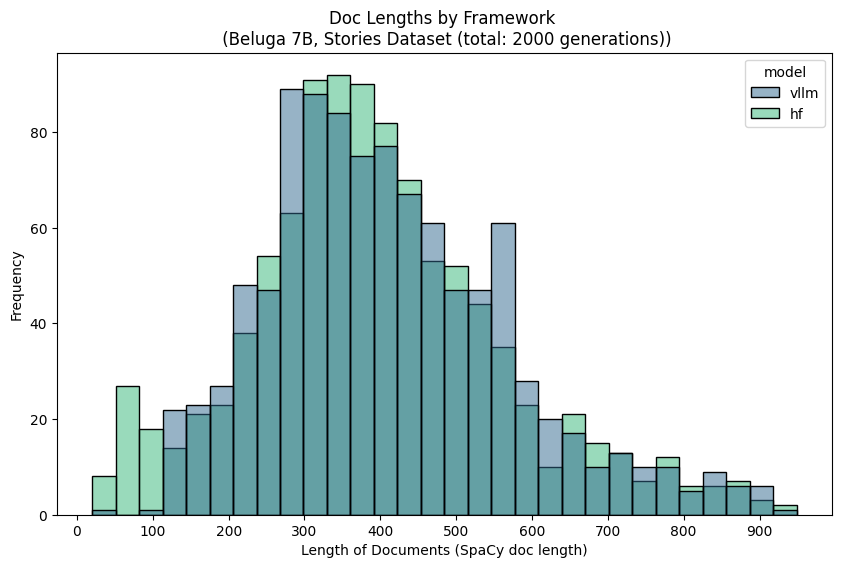

In [14]:
# plot
plt.figure(figsize=(10, 6))
sns.histplot(data=combined_df, x='doc_length', hue="model", kde=False, bins=30, palette='viridis')

# adjust
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(100))
plt.title("Doc Lengths by Framework \n (Beluga 7B, Stories Dataset (total: 2000 generations))")
plt.xlabel('Length of Documents (SpaCy doc length)')
plt.ylabel('Frequency')

### Distances

In [ ]:
# compute PCA
from utils.pca import get_descriptive_metrics, run_PCA

print("[INFO:] EXTRACTING LOW LEVEL METRICS")
metrics_df = get_descriptive_metrics(combined_df, "beluga7b_completions", "id")

print("[INFO:] RUNNING PCA ...")
pca, pca_df = run_PCA(metrics_df, feature_names=["doc_length", "n_tokens", "n_characters", "n_sentences"], n_components=4)

In [110]:
# compute distance
from utils.distance import compute_distances
pca_df["prompt_number"] = 1
pca_df.rename(columns={"beluga7b_completions": "completions"}, inplace=True)
distance_df = compute_distances(pca_df, models=["vllm"], baseline="hf", include_baseline_completions=True)

Text(0.5, 1.0, 'Distance between VLLM and HF \n Stories dataset')

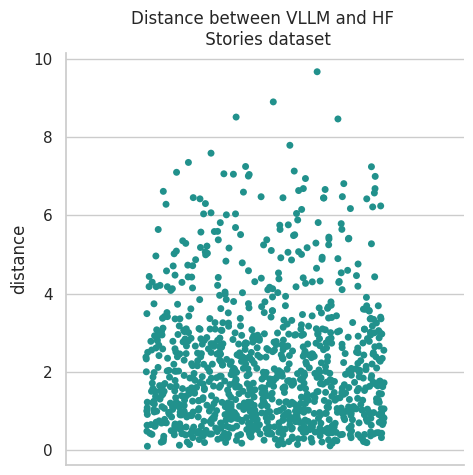

In [112]:
sns.set(style="whitegrid")
g = sns.catplot(data=distance_df, x="prompt_number", y="distance", kind="strip", jitter=0.3, palette="viridis", hue="prompt_number")
g.set(xlabel=None, xticklabels=[])
g._legend.remove()
plt.title("Distance between VLLM and HF \n Stories dataset")

## Peaking at the Data

In [3]:
## loading 
from utils.process_generations import preprocess_datasets
ai_dir = path.parents[0] / "datasets" / "ai_datasets" / "vLLM" / "FULL_DATA"
human_dir = path.parents[0] / "datasets" / "human_datasets"

models = ["beluga7b", "llama2_chat13b", "mistral7b"]
datasets = ["dailymail_cnn", "stories", "mrpc", "dailydialog"]

print("[INFO:] Preprocessing datasets ...")
df = preprocess_datasets(ai_dir, human_dir, models, datasets)

[INFO:] Preprocessing datasets ...


In [47]:
def print_example_from_each_model(df, dataset_name, row_index=0):
    models = df[df["dataset"] == dataset_name]["model"].unique()
    
    for model in models:
        example_completion = df[(df["dataset"] == dataset_name) & (df["model"] == model)].reset_index(drop=True)["completions"].iloc[row_index]
        print(f"MODEL: {model.upper()}\n{example_completion}\n")  
    
    # print source for row
    source = (df[df["dataset"] == dataset_name]["source"].iloc[row_index])
    print(f"SOURCE:\n {source}")

### Example Generations

#### DailyMail CNN
Current prompt: "write a short summarized text of the news article: SOURCE TEXT INSERTED HERE ...." 

In [48]:
print_example_from_each_model(df, "dailymail_cnn", row_index=20)

MODEL: HUMAN
richard griffiths laid to rest at holy trinity church in stratford-upon-avon .
daniel radcliffe weeps as he leads tributes to beloved star of withnail and i .
nigel havers, lord fellowes and jack whitehall attend moving ceremony .
richard e. grant sends card: 'to my beloved .
uncle monty, chin chin'

MODEL: BELUGA7B
 Actor Daniel Radcliffe mourned at the funeral of friend and fellow actor Richard Griffiths, who starred in Withnail and I, Pie in the Sky, and The History Boys. Radcliffe led tributes and was visibly upset throughout the ceremony, sharing the stage with many popular UK celebrities and actors. Griffiths' funeral service was held at Holy Trinity Church in Stratford-upon-Avon, with mourners paying their respects to a beloved and prominent actor in the UK scene.

MODEL: LLAMA2_CHAT13B
  Here is a summarized version of the news article:

Actor Richard Griffiths was laid to rest at Holy Trinity Church in Stratford-upon-Avon today, where William Shakespeare is buried

#### Stories
Current prompt:  "continue the story: SOURCE TEXT INSERTED HERE ...."

In [69]:
#### Stories
print_example_from_each_model(df, "stories", row_index=1580)

MODEL: HUMAN
ding!'' *another one, * i thought to myself as a ( 1 ) showed up on my inbox icon at the top tab. thank you for booking american airlines!'' it read. taking a break from typing boring numbers into an excel sheet, i clicked on the tab. <newline> <newline> *i've already gotten 2 flight emails, 3 hotel confirmations, and a rental car confirmation. why does this keep happening? * rolling my eyes, i opened up the e-mail, and quickly scanned it, hoping i would be able to get into contact with the guy who had been sending e-mails to the wrong e-mail address. sfo to las. . .'' i muttered. pausing, my heart raced. pulling up my calendar, i looked at the dates that the e-mail had mentioned. the dates happened to be this friday. . . and it just so happened that i didn't have work that day. *should i do it? * i wondered, looking around the office, lest the person booking these was in close proximity to me. my heart beat faster, begging for a decision to be made. the airport was local,

#### MRPC
Current prompt: "paraphrase this: SOURCE TEXT INSERTED HERE ...." 

See below - is it paraphrasing if the model adds more information ;)? 

In [70]:
print_example_from_each_model(df, "mrpc", row_index=1000)

MODEL: HUMAN
xerox itself previously paid a $10-million penalty to settle the sec accusations.

MODEL: BELUGA7B
 Xerox company, also known as a copier manufacturer, was required to pay a $10 million fine in the past year to resolve the same allegations made by the Securities and Exchange Commission (SEC).

MODEL: LLAMA2_CHAT13B
  Xerox agreed to pay $10 million in penalties last year to resolve similar Securities and Exchange Commission (SEC) charges.

MODEL: MISTRAL7B
 Last year, Xerox paid a fine of $10 million to resolve similar securities-related charges brought by the Securities and Exchange Commission (SEC).

SOURCE:
 xerox itself paid a $10 million fine last year to settle similar sec charges.


#### DailyDialog
Current prompt: "continue the following conversation by writing a single response to the last speaker. write only a concise response and nothing else: SOURCE TEXT INSERTED HERE ..."

In [71]:
print_example_from_each_model(df, "dailydialog", row_index=1000)

MODEL: HUMAN
not at all. welcome again.

MODEL: BELUGA7B
 You're welcome, sir! Enjoy your day.

MODEL: LLAMA2_CHAT13B
  Sure! Here's my response:

The total charge is five hundred and thirty yuan, including all fees and services.

MODEL: MISTRAL7B
 Here is the total amount due: 五百 thirty元. (Five hundred and thirty yuan.)

SOURCE:
 good morning, sir. may i help you? speaker 2: good morning. i'd like to pay my bill. speaker 1: ok. in cash or by credit? speaker 2: in cash. how much is the total charge? speaker 1: five hundred and thirty yuan altogether including charges for service. speaker 2: here you are. thanks for your wonderful service.


In [77]:
print_example_from_each_model(df, "dailydialog", row_index=700)

MODEL: HUMAN
if i were you, i'd buy.

MODEL: BELUGA7B
 speaker 1: I would say let's weigh pros and cons and thoroughly evaluate the option before making a decision.

MODEL: LLAMA2_CHAT13B
  Sure, here is my response:

If I were you, I would consider our budget and the features we need in a new car before making a decision.

MODEL: MISTRAL7B
 Speaker 2: I would carefully consider the pros and cons before making a decision.

SOURCE:
 shall we buy? speaker 2: it really depends on you. speaker 1: but if you were me?


## Help Wanted

**1 Choosing prompts**<br>
Not sure how big of an impact prompts do, I have chosen those with the lowest median distance (that was common between models, see [results/README.md](https://github.com/rbroc/echo/tree/main/results)) except for `dailydialog` which has been a bunch of playing around. It is difficult when there is so much data! 

**2 Choosing Hyperparams**<br>
Was thinking we keep k=50, and maybe run a few different temperatures? and nothing else? 

**3 Generation Issues**
Some overall isues with generations:
* Some generations still start with sure esp. with LLama
* Dailydialog - cannot make it NOT start with speaker 1 and speaker 2 at least sometimes. 
* Prompting may be affected by large source texts. E.g., “write a response to the dialog: ….. 100 chars of text” -> it may have forgotten the prompt ? (not sure, but an intution) 

**4 vLLM Issues**<br>
Sometimes vLLM bugs and barely generates tokens. Seems to be mainly a problem for stories (increasing temperature from 1 to 3 also seemed to make it worse), and it is heavy to generate +30 outputs for each prompt, so the solution has been: 
1. Identify problematic rows after generation by extracting doc lengths for all
2. Increase n outputs (`n` parameter in vLLM's `SamplingParams` obj) per prompt by 1 until problematic rows meet the required min token length OR the threshold of n=30 is met 

Potential problems with this approach: 
* If it fails to find an output after 30 examples, we will have some incomplete completions (but seems to be only between 1-5 completions in the stories dataset depending on the model)
* If we are using a smaller machine (smaller than one A100), we may experience that it crashes when increasing n outputs. 

Alternatively, we can set a random seed (from a generated list of seeds to ensure reproducibility), but this would require to load the model multiple times which is also not sustainable when loading a bigger model. 

**5 practical thing for Roberta**<br>
Can we protect the main branch :))?